In [ ]:
import rasterio 
from rasterio.merge import merge
import rasterio.plot
from rasterio.windows import Window
from rasterio.plot import show
import glob
from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tables
import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from tqdm import tqdm
import matplotlib.pyplot as plt

# from osgeo import gdal
project_id = 'moja-328209'
!gcloud config set project {project_id}
!gsutil ls
np.seterr(divide='ignore', invalid='ignore')

Updated property [core/project].
gs://data-myanmar-new/
gs://data-new-phil/
gs://data-phil-new-patch/
gs://data-philippines-new/
gs://data-uganda/
gs://philippines-backup-new/


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
src = rasterio.open('/data/uganda/budongo/corrected/2001_resampled.tif')
X_train = src.read()
X_train=X_train.reshape(11,965*965)
src.close()

src = rasterio.open('/data/uganda/budongo/matt/2001_resampled.tif')
y_train = src.read()
y_train=y_train.reshape(1*965*965)
src.close()

for year in range(2002,2016):
  src = rasterio.open('/data/uganda/budongo/corrected/{}_resampled.tif'.format(year))
  X = src.read()
  X=X.reshape(11,965*965)
  X_train=np.hstack([X_train,X])
  src.close()
  del X
  src = rasterio.open('/data/uganda/budongo/matt/{}_resampled.tif'.format(year))
  X = src.read()
  X=X.reshape(1*965*965)
  y_train=np.hstack([y_train,X])
  src.close()
  del X


In [ ]:
X_train=X_train.T

In [ ]:
X_train.shape

(13968375, 11)

# Logistic regression

In [ ]:
scaler=MinMaxScaler()

In [ ]:
X_train=scaler.fit_transform(X_train)

In [ ]:
y_train[y_train<=28]=0
y_train[y_train>28]=1

In [ ]:
lr=LogisticRegression(max_iter=1e6)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000000.0)

In [ ]:
src = rasterio.open('/data/uganda/budongo/corrected/2001_resampled.tif')
X_test = src.read()
X_test=X_test.reshape(11,965*965)
src.close()

src = rasterio.open('/data/uganda/budongo/matt/2001_resampled.tif')
y_test = src.read()
y_test =y_test.reshape(1*965*965)
src.close()

for year in range(2002,2016):
  src = rasterio.open('/data/uganda/budongo/corrected/{}_resampled.tif'.format(year))
  X = src.read()
  X=X.reshape(11,965*965)
  X_test=np.hstack([X_test,X])
  src.close()
  del X
  src = rasterio.open('/data/uganda/budongo/matt/{}_resampled.tif'.format(year))
  X = src.read()
  X=X.reshape(1*965*965)
  y_test=np.hstack([y_test,X])
  src.close()
  del X
X_test=X_test.T

In [ ]:
y_pred=lr.predict(X_test)

In [ ]:
y_test[y_test<=28]=0
y_test[y_test>28]=1

In [ ]:
lr.score(X_test,y_test)

0.676751805417595

In [ ]:
roc_auc_score(y_test,y_pred)

0.6846823435288968

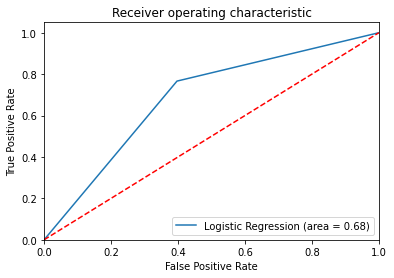

In [ ]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
confusion_matrix(y_test,y_pred)

array([[4620394, 3041913],
       [1473339, 4832729]])

In [ ]:
accuracy_score(y_test,y_pred)

0.676751805417595

In [ ]:
f1_score(y_test,y_pred)

0.681591965423452

In [ ]:
precision=precision_score(y_test,y_pred)
precision

0.6137077723660327

In [ ]:
recall=recall_score(y_test,y_pred)
recall

0.7663617011424552

# Feature importance

In [ ]:
X_train[:1000,:].shape
# y_train.shape

(1000, 11)

In [ ]:
gb = GradientBoostingRegressor(n_estimators=100)


In [ ]:
print(y_train.shape)


(13968375,)


([<matplotlib.axis.XTick at 0x7f94c0dce190>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11')])

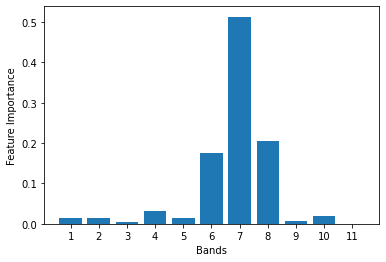

In [ ]:
gb.fit(X_train[:100000,:],y_train[:100000])
plt.bar(range(X_train.shape[1]), gb.feature_importances_)
plt.xlabel("Bands")
plt.ylabel("Feature Importance")
plt.xticks(range(X_train.shape[1]), ['1','2','3','4','5','6','7','8','9','10','11'])